<font size=6><b>펀드 운용모델
* 참고: 실습06_펀드_운용모델.xlsx

In [1]:
from pykrx import stock
from pykrx import bond
import FinanceDataReader as fdr

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time


import warnings
warnings.filterwarnings(action='ignore')

sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load

## 시총 Top 5 업종명, 업종코드
* LG에너지솔루션, 삼성전자우 제외

In [2]:
start_data='20200101'
end_data='20221229'

df = stock.get_market_cap(end_data) 
top5_ticker = df.sort_values(by='시가총액', ascending=False).index[:7]
top5_name = []
for ticker in top5_ticker:
    names = stock.get_market_ticker_name(ticker)
    top5_name.append(names)
    print(ticker, names)
    time.sleep(1)  
    
top5_ticker = list(top5_ticker)

top5_ticker.remove('373220')
top5_ticker.remove('005935')

top5_name.remove('LG에너지솔루션')
top5_name.remove('삼성전자우')

print(len(top5_ticker), top5_ticker)
print(len(top5_name), top5_name)

005930 삼성전자
373220 LG에너지솔루션
207940 삼성바이오로직스
000660 SK하이닉스
051910 LG화학
005935 삼성전자우
006400 삼성SDI
5 ['005930', '207940', '000660', '051910', '006400']
5 ['삼성전자', '삼성바이오로직스', 'SK하이닉스', 'LG화학', '삼성SDI']


## 종목 기본정보
* 상장주식수, 유동비율
* fnguide 크롤링

In [3]:
from bs4 import BeautifulSoup
import requests
import re

In [4]:
발생주식수_list = []
유동비율_list = []
유동주식수_list = []

for ticker in top5_ticker:
    res = requests.get(f"https://comp.fnguide.com/SVO2/ASP/SVD_main.asp?pGB=1&gicode=A{ticker}&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=&strResearchYN=")
    soup = BeautifulSoup(res.text, 'html.parser')
    
    trdata = soup.select("#svdMainGrid1> table > tbody > tr")
    td = trdata[5].select("td")
    
    발행주식수 = td[0].text
    발행주식수 = 발행주식수.split("/")[0].strip()
    발행주식수 = int(''.join(re.findall('[\d.]+', 발행주식수)))
    
    유동비율 = td[1].text
    유동비율 = 유동비율.split('/')[1].strip()
    유동비율= float(유동비율)
    
    유동주식수 = td[1].text
    유동주식수 = 유동주식수.split('/')[0].strip()
    유동주식수 = int(''.join(re.findall('[\d.]+', 유동주식수)))
    
    발생주식수_list.append(발행주식수)
    유동비율_list.append(유동비율)
    유동주식수_list.append(유동주식수)
    
    print(발행주식수, 유동비율, 유동주식수)
    
    time.sleep(1)

5969782550 75.81 4525870769
71174000 24.76 17623664
728002365 73.87 537759511
70592343 66.63 47036786
68764530 73.16 50306427


In [5]:
발생주식수_list

[5969782550, 71174000, 728002365, 70592343, 68764530]

In [6]:
유동비율_list

[75.81, 24.76, 73.87, 66.63, 73.16]

In [7]:
유동주식수_list  

[4525870769, 17623664, 537759511, 47036786, 50306427]

## 일자별 주가

In [8]:
주가_list = []
for ticker in top5_ticker:
    names = stock.get_market_ticker_name(ticker)
    print(ticker)
    closev = stock.get_market_ohlcv(start_data, end_data, ticker)[['종가']]
    closev.columns = [names]
    주가_list.append(closev)
    time.sleep(1)  
    
주가_df = pd.concat(주가_list, axis=1)  
주가_df.head()

005930


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
주가_df.to_csv('실습07_일자별주가.csv')

* <font color=red><b>API 막혀있을 경우 아래 코드로 대체

In [9]:
주가_df = pd.read_csv("실습07_일자별주가.csv",  parse_dates=["날짜"])
주가_df = 주가_df.set_index("날짜")
주가_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,
2020-01-02,55200,423485,94700,314000,232000
2020-01-03,55500,417061,94500,311000,229000
2020-01-06,55500,407178,94300,307000,230000
2020-01-07,55800,414096,94000,311000,231500
2020-01-08,56800,403719,97400,302000,229000


# 일자별 시가 총액

In [10]:
# 유동주식수 = np.array(발생주식수_list) * np.array(유동비율_list)*0.01
# 시가총액_df = 주가_df*유동주식수
시가총액_df = 주가_df*np.array(유동주식수_list)
시가총액_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,
2020-01-02,249828066448800,7463357349040,50925825691700,14769550804000,11671091064000
2020-01-03,251185827679500,7350142931504,50818273789500,14628440446000,11520171783000
2020-01-06,251185827679500,7175968260192,50710721887300,14440293302000,11570478210000
2020-01-07,252543588910200,7297888767744,50549394034000,14628440446000,11645937850500
2020-01-08,257069459679200,7115008006416,52377776371400,14205109372000,11520171783000


In [11]:
# 시가총액_df['합계'] = 시가총액_df.iloc[:,0]+시가총액_df.iloc[:,1]+시가총액_df.iloc[:,2]+시가총액_df.iloc[:,3]+시가총액_df.iloc[:,4]
시가총액_df['합계'] = 시가총액_df.sum(axis=1)
시가총액_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,합계
날짜,,,,,,
2020-01-02,249828066448800,7463357349040,50925825691700,14769550804000,11671091064000,334657891357540
2020-01-03,251185827679500,7350142931504,50818273789500,14628440446000,11520171783000,335502856629504
2020-01-06,251185827679500,7175968260192,50710721887300,14440293302000,11570478210000,335083289338992
2020-01-07,252543588910200,7297888767744,50549394034000,14628440446000,11645937850500,336665250008444
2020-01-08,257069459679200,7115008006416,52377776371400,14205109372000,11520171783000,342287525212016


In [12]:
시가총액_df['지수'] = 시가총액_df['합계']/시가총액_df.iloc[0,5]
시가총액_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,합계,지수
날짜,,,,,,,
2020-01-02,249828066448800,7463357349040,50925825691700,14769550804000,11671091064000,334657891357540,1.000000
2020-01-03,251185827679500,7350142931504,50818273789500,14628440446000,11520171783000,335502856629504,1.002525
2020-01-06,251185827679500,7175968260192,50710721887300,14440293302000,11570478210000,335083289338992,1.001271
2020-01-07,252543588910200,7297888767744,50549394034000,14628440446000,11645937850500,336665250008444,1.005998
2020-01-08,257069459679200,7115008006416,52377776371400,14205109372000,11520171783000,342287525212016,1.022798


# 펀드

## 편입비중

In [13]:
편입비중_df = 시가총액_df[top5_name]
편입비중_df = 편입비중_df.div(시가총액_df['합계'], axis=0)
편입비중_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,
2020-01-02,0.746518,0.022301,0.152173,0.044133,0.034875
2020-01-03,0.748685,0.021908,0.151469,0.043602,0.034337
2020-01-06,0.749622,0.021415,0.151338,0.043095,0.034530
2020-01-07,0.750133,0.021677,0.150147,0.043451,0.034592
2020-01-08,0.751034,0.020787,0.153023,0.041501,0.033656


## 설정좌수, 환매좌수

In [14]:
좌수 = pd.read_csv('실습07_설정환매_랜덤.csv', parse_dates=['날짜'])
좌수 = 좌수.set_index('날짜')
좌수.head()

,설정,환매
날짜,,
2020-01-02,1000000,0
2020-01-03,50000,0
2020-01-06,150000,100000
2020-01-07,100000,100000
2020-01-08,150000,100000


In [15]:
좌수['총좌수'] = (좌수['설정']-좌수['환매']).cumsum()
좌수.head()

,설정,환매,총좌수
날짜,,,
2020-01-02,1000000,0,1000000
2020-01-03,50000,0,1050000
2020-01-06,150000,100000,1100000
2020-01-07,100000,100000,1100000
2020-01-08,150000,100000,1150000


## iNAV

In [16]:
기준가 = 10000
iNAV = (시가총액_df['지수']/시가총액_df['지수'][0])*기준가
# iNAV = iNAV.astype(int)
iNAV

날짜
2020-01-02    10000.000000
2020-01-03    10025.248628
2020-01-06    10012.711428
2020-01-07    10059.982409
2020-01-08    10227.983085
                  ...     
2022-12-23    11324.355459
2022-12-26    11307.129031
2022-12-27    11351.391665
2022-12-28    11065.406784
2022-12-29    10847.938277
Name: 지수, Length: 742, dtype: float64

## AUM

In [17]:
AUM = iNAV*좌수['총좌수']
AUM

날짜
2020-01-02    1.000000e+10
2020-01-03    1.052651e+10
2020-01-06    1.101398e+10
2020-01-07    1.106598e+10
2020-01-08    1.176218e+10
                  ...     
2022-12-23    4.240971e+11
2022-12-26    4.240173e+11
2022-12-27    4.268123e+11
2022-12-28    4.166126e+11
2022-12-29    4.089673e+11
Length: 742, dtype: float64

## 일자별 매매내역

In [18]:
주식잔고_df = 편입비중_df[top5_name]

주식잔고_df = 주식잔고_df.mul(AUM, axis=0)
주식잔고_df = 주식잔고_df.div(주가_df)

주식잔고_df = 주식잔고_df.astype(int)

주식잔고_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,
2020-01-02,135238,526,16068,1405,1503
2020-01-03,142000,552,16872,1475,1578
2020-01-06,148762,579,17675,1546,1653
2020-01-07,148762,579,17675,1546,1653
2020-01-08,155524,605,18479,1616,1728


In [19]:
매매내역_df = 주식잔고_df.diff()
매매내역_df.iloc[0,:] = 주식잔고_df.iloc[0,:]
매매내역_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,
2020-01-02,135238.0,526.0,16068.0,1405.0,1503.0
2020-01-03,6762.0,26.0,804.0,70.0,75.0
2020-01-06,6762.0,27.0,803.0,71.0,75.0
2020-01-07,0.0,0.0,0.0,0.0,0.0
2020-01-08,6762.0,26.0,804.0,70.0,75.0


## Total Fund Result

In [20]:
fdf = pd.concat([편입비중_df,시가총액_df['지수'],  좌수, iNAV, AUM, 매매내역_df, 주식잔고_df], axis=1)
fdf.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,지수,설정,환매,총좌수,지수,0,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.746518,0.022301,0.152173,0.044133,0.034875,1.000000,1000000,0,1000000,10000.000000,1.000000e+10,135238.0,526.0,16068.0,1405.0,1503.0,135238,526,16068,1405,1503
2020-01-03,0.748685,0.021908,0.151469,0.043602,0.034337,1.002525,50000,0,1050000,10025.248628,1.052651e+10,6762.0,26.0,804.0,70.0,75.0,142000,552,16872,1475,1578
2020-01-06,0.749622,0.021415,0.151338,0.043095,0.034530,1.001271,150000,100000,1100000,10012.711428,1.101398e+10,6762.0,27.0,803.0,71.0,75.0,148762,579,17675,1546,1653
2020-01-07,0.750133,0.021677,0.150147,0.043451,0.034592,1.005998,100000,100000,1100000,10059.982409,1.106598e+10,0.0,0.0,0.0,0.0,0.0,148762,579,17675,1546,1653
2020-01-08,0.751034,0.020787,0.153023,0.041501,0.033656,1.022798,150000,100000,1150000,10227.983085,1.176218e+10,6762.0,26.0,804.0,70.0,75.0,155524,605,18479,1616,1728


In [21]:
fdf.columns = ['편입비중_삼성전자', '편입비중_삼성바이오로직스', '편입비중_SK하이닉스', '편입비중_LG화학', '편입비중_삼성SDI',
              '지수', '설정좌수', '환매좌수', '총좌수', 'iNAV', 'AUM',
              '매매내역_삼성전자', '매매내역_삼성바이오로직스', '매매내역_SK하이닉스', '매매내역_LG화학', '매매내역_삼성SDI',
              '주식잔고_삼성전자', '주식잔고_삼성바이오로직스', '주식잔고_SK하이닉스', '주식잔고_LG화학', '주식잔고_삼성SDI']
fdf.head()

,편입비중_삼성전자,편입비중_삼성바이오로직스,편입비중_SK하이닉스,편입비중_LG화학,편입비중_삼성SDI,지수,설정좌수,환매좌수,총좌수,iNAV,AUM,매매내역_삼성전자,매매내역_삼성바이오로직스,매매내역_SK하이닉스,매매내역_LG화학,매매내역_삼성SDI,주식잔고_삼성전자,주식잔고_삼성바이오로직스,주식잔고_SK하이닉스,주식잔고_LG화학,주식잔고_삼성SDI
날짜,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.746518,0.022301,0.152173,0.044133,0.034875,1.000000,1000000,0,1000000,10000.000000,1.000000e+10,135238.0,526.0,16068.0,1405.0,1503.0,135238,526,16068,1405,1503
2020-01-03,0.748685,0.021908,0.151469,0.043602,0.034337,1.002525,50000,0,1050000,10025.248628,1.052651e+10,6762.0,26.0,804.0,70.0,75.0,142000,552,16872,1475,1578
2020-01-06,0.749622,0.021415,0.151338,0.043095,0.034530,1.001271,150000,100000,1100000,10012.711428,1.101398e+10,6762.0,27.0,803.0,71.0,75.0,148762,579,17675,1546,1653
2020-01-07,0.750133,0.021677,0.150147,0.043451,0.034592,1.005998,100000,100000,1100000,10059.982409,1.106598e+10,0.0,0.0,0.0,0.0,0.0,148762,579,17675,1546,1653
2020-01-08,0.751034,0.020787,0.153023,0.041501,0.033656,1.022798,150000,100000,1150000,10227.983085,1.176218e+10,6762.0,26.0,804.0,70.0,75.0,155524,605,18479,1616,1728


In [22]:
fdf.tail()

,편입비중_삼성전자,편입비중_삼성바이오로직스,편입비중_SK하이닉스,편입비중_LG화학,편입비중_삼성SDI,지수,설정좌수,환매좌수,총좌수,iNAV,AUM,매매내역_삼성전자,매매내역_삼성바이오로직스,매매내역_SK하이닉스,매매내역_LG화학,매매내역_삼성SDI,주식잔고_삼성전자,주식잔고_삼성바이오로직스,주식잔고_SK하이닉스,주식잔고_LG화학,주식잔고_삼성SDI
날짜,,,,,,,,,,,,,,,,,,,,,
2022-12-23,0.693847,0.037481,0.110396,0.075710,0.082566,1.132436,50000,0,37450000,11324.355459,4.240971e+11,6762.0,26.0,803.0,70.0,75.0,5064690,19721,601781,52636,56295
2022-12-26,0.692512,0.038284,0.109427,0.076820,0.082957,1.130713,150000,100000,37500000,11307.129031,4.240173e+11,6762.0,27.0,803.0,70.0,75.0,5071452,19748,602584,52706,56370
2022-12-27,0.692194,0.038413,0.109001,0.077758,0.082634,1.135139,200000,100000,37600000,11351.391665,4.268123e+11,13524.0,52.0,1607.0,141.0,151.0,5084976,19800,604191,52847,56521
2022-12-28,0.691752,0.039501,0.110365,0.076466,0.081917,1.106541,100000,50000,37650000,11065.406784,4.166126e+11,6762.0,27.0,804.0,70.0,75.0,5091738,19827,604995,52917,56596
2022-12-29,0.689412,0.039856,0.111097,0.077739,0.081896,1.084794,100000,50000,37700000,10847.938277,4.089673e+11,6762.0,26.0,803.0,71.0,75.0,5098500,19853,605798,52988,56671


In [23]:
fdf.to_csv("실습07_펀드_운용모델_최종.csv")

# 수익률 비교

In [24]:
fdf = pd.read_csv("실습07_펀드_운용모델_최종.csv", parse_dates=['날짜'])
fdf = fdf.set_index("날짜")
fdf.head()

,편입비중_삼성전자,편입비중_삼성바이오로직스,편입비중_SK하이닉스,편입비중_LG화학,편입비중_삼성SDI,지수,설정좌수,환매좌수,총좌수,iNAV,AUM,매매내역_삼성전자,매매내역_삼성바이오로직스,매매내역_SK하이닉스,매매내역_LG화학,매매내역_삼성SDI,주식잔고_삼성전자,주식잔고_삼성바이오로직스,주식잔고_SK하이닉스,주식잔고_LG화학,주식잔고_삼성SDI
날짜,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.746518,0.022301,0.152173,0.044133,0.034875,1.000000,1000000,0,1000000,10000.000000,1.000000e+10,135238.0,526.0,16068.0,1405.0,1503.0,135238,526,16068,1405,1503
2020-01-03,0.748685,0.021908,0.151469,0.043602,0.034337,1.002525,50000,0,1050000,10025.248628,1.052651e+10,6762.0,26.0,804.0,70.0,75.0,142000,552,16872,1475,1578
2020-01-06,0.749622,0.021415,0.151338,0.043095,0.034530,1.001271,150000,100000,1100000,10012.711428,1.101398e+10,6762.0,27.0,803.0,71.0,75.0,148762,579,17675,1546,1653
2020-01-07,0.750133,0.021677,0.150147,0.043451,0.034592,1.005998,100000,100000,1100000,10059.982409,1.106598e+10,0.0,0.0,0.0,0.0,0.0,148762,579,17675,1546,1653
2020-01-08,0.751034,0.020787,0.153023,0.041501,0.033656,1.022798,150000,100000,1150000,10227.983085,1.176218e+10,6762.0,26.0,804.0,70.0,75.0,155524,605,18479,1616,1728


## KOSPI vs. BOND10Y vs. ASIA5-Fund
* ref : https://github.com/sharebook-kr/pykrx
<pre>
for ticker in stock.get_index_ticker_list():
    print(ticker, stock.get_index_ticker_name(ticker))
1001 코스피
1028 코스피 200
1034 코스피 100

In [25]:
# 인덱스 구성종목 조회
pdf = stock.get_index_portfolio_deposit_file("1001")
print(len(pdf), pdf[:3])

824 ['005930', '373220', '000660']


In [26]:
# # 인덱스 OHLCV
# kospi_df = stock.get_index_ohlcv("20200101", "20221231", "1001")
# kospi_df.head()

In [27]:
import yfinance as yf
# tickers      = ['^GSPC', '^KS11','IEF', '148070.KS'] # 주식:지수,  채권:10년물 국채 
tickers      = ['^KS11','148070.KS'] # 주식:지수,  채권:10년물 국채 
start_date = '2020-01-01'
end_date = '2022-12-31'

sample=pd.DataFrame()
for i, ticker in enumerate(tickers):
    ticker = yf.Ticker(ticker)
    s = ticker.history(interval='1d', start=start_date, end=end_date, auto_adjust=False)[['Close']]
    s.index = pd.to_datetime(s.index.strftime('%Y-%m-%d'), format='%Y-%m-%d')
    sample = pd.concat([sample, s], axis=1)
    
# sample.columns = ['S&P500', 'KOSPI', 'US-BOND10Y', 'KR-BOND10Y']
sample.columns = ['KOSPI', 'BOND10Y']
sample.head()

,KOSPI,BOND10Y
Date,,
2020-01-02,2175.169922,123285.0
2020-01-03,2176.459961,124030.0
2020-01-06,2155.070068,124360.0
2020-01-07,2175.540039,123590.0
2020-01-08,2151.310059,123360.0


In [28]:
sample['KOSPI지수'] = sample['KOSPI'] / sample.iloc[0]['KOSPI']
sample['BOND10지수'] = sample['BOND10Y'] / sample.iloc[0]['BOND10Y']
sample.head()

,KOSPI,BOND10Y,KOSPI지수,BOND10지수
Date,,,,
2020-01-02,2175.169922,123285.0,1.000000,1.000000
2020-01-03,2176.459961,124030.0,1.000593,1.006043
2020-01-06,2155.070068,124360.0,0.990759,1.008720
2020-01-07,2175.540039,123590.0,1.000170,1.002474
2020-01-08,2151.310059,123360.0,0.989031,1.000608


In [29]:
fdf.shape, sample.shape

((742, 21), (740, 4))

In [30]:
# fdf 날짜 sampe: Date
tot = pd.merge(sample[['KOSPI지수','BOND10지수']], fdf["지수"], left_index=True, right_index=True)
tot.columns = ['KOSPI지수','BOND10지수','아시아5지수']
tot.head()

,KOSPI지수,BOND10지수,아시아5지수
2020-01-02,1.000000,1.000000,1.000000
2020-01-03,1.000593,1.006043,1.002525
2020-01-06,0.990759,1.008720,1.001271
2020-01-07,1.000170,1.002474,1.005998
2020-01-08,0.989031,1.000608,1.022798


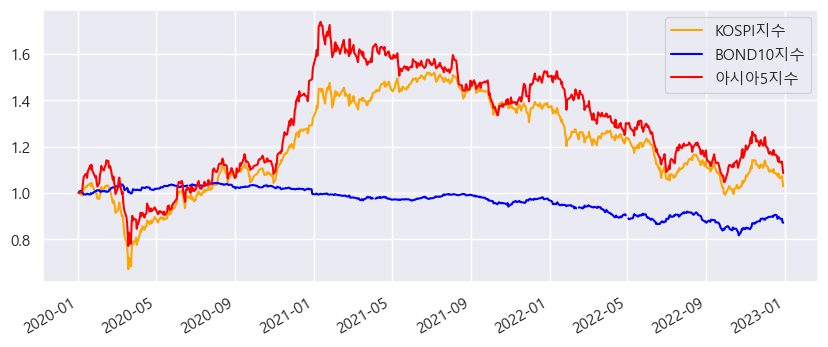

In [31]:
# pd.options.plotting.backend = "plotly"   
tot.plot(color=['orange','blue','red'], figsize=(10,4))
plt.show()

## 일간 변동률

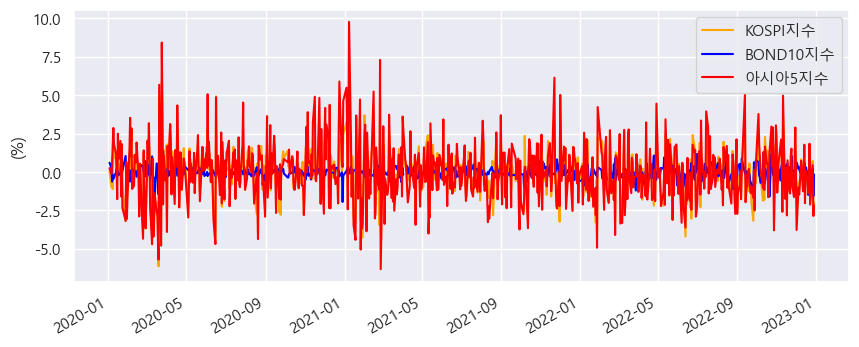

In [50]:
(tot.diff()*100).plot(color=['orange','blue','red'], figsize=(10,4))
plt.ylabel('(%)')
plt.show()

## 추적오차율 
* 추적오차율 = 펀드수익률 - 지수수익률

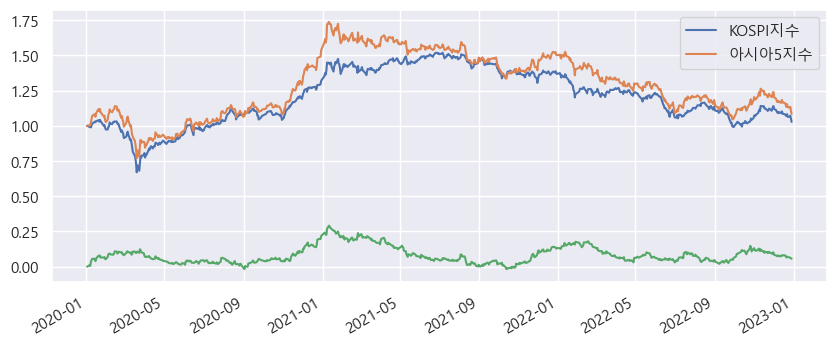

In [55]:
# KOSPI200 대비 일간 추적오차율 
tot[['KOSPI지수','아시아5지수']].plot(figsize=(10,4))
# plt.show()
(tot['아시아5지수']-tot['KOSPI지수']).plot(figsize=(10,4))
plt.show()

## 수익률

* 연간 기대수익률

In [33]:
r = tot.pct_change() 
연간기대수익률 = np.log(1+ r).mean() * 252
print(연간기대수익률)

연간공분산행렬 = np.log(1+ r).cov() * 252
print(연간공분산행렬)


KOSPI지수     0.009466
BOND10지수   -0.047244
아시아5지수      0.027754
dtype: float64
           KOSPI지수  BOND10지수    아시아5지수
KOSPI지수   0.047519  0.001435  0.050100
BOND10지수  0.001435  0.004374  0.001259
아시아5지수    0.050100  0.001259  0.066465


* pyportfolioopt

In [34]:
# 권한문제 발생(pycharm에서 설치)
# ! pip install pyportfolioopt

In [35]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [36]:
mu = expected_returns.mean_historical_return(tot)
S = risk_models.sample_cov(tot)
print(mu)
print(S)
print()
# ef = EfficientFrontier(mu, S)
# weights = ef.max_sharpe()
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)
# ef.portfolio_performance(verbose=True)

KOSPI지수     0.009511
BOND10지수   -0.046145
아시아5지수      0.028143
dtype: float64
           KOSPI지수  BOND10지수    아시아5지수
KOSPI지수   0.047472  0.001407  0.050268
BOND10지수  0.001407  0.004365  0.001249
아시아5지수    0.050268  0.001249  0.067008



* 기간 수익률

In [37]:
N = 2
기간수익률_몇배 = np.round( (tot.iloc[-1] / tot.iloc[0] ) , 1)
연복리수익률r = ((기간수익률_몇배 ** (1/N))-1) * 100
print(f"기간수익률 : \n {기간수익률_몇배} ")
print()
print(f"연복리 : \n {연복리수익률r} ")

기간수익률 : 
 KOSPI지수     1.0
BOND10지수    0.9
아시아5지수      1.1
dtype: float64 

연복리 : 
 KOSPI지수     0.000000
BOND10지수   -5.131670
아시아5지수      4.880885
dtype: float64 


# 포트폴리오

## 효율적 투자선

In [38]:
#  port_var = np.sqrt(np.dot(weights.T, np.dot(cov, weights)) * 250)
dret = tot.pct_change().mean()                  #일별 변동률
aret = tot.pct_change().mean().dropna() *252    #년간 변동률
dcov = tot.pct_change().cov()                   #일분산
acov = tot.pct_change().cov() * 252             #년분산

weights_list = []
ret_list     = []
risk_list    = []
sharp_list   = []
for i in range(10000):
    w = np.random.rand(tot.shape[1])  #포트에 편성할 종목 갯수 3개
    w = w / np.sum(w)
    weights_list.append(w)
    
    # 가중평균 수익률 (p1w1 + p2w2 ... pnwn) --> np.dot(p, wT) 
    ret = np.dot(aret, w)
    ret_list.append(ret)
    
    #risk(편차) =  np.sqrt(W.cov.WT)
    risk = np.sqrt(np.dot(w.T, np.dot(acov, w)))
    risk_list.append(risk)
    
    # 샤프 : (수익률-무위험수익률)/표준편차(리스크)
    # 샤프지수가 높다 == 수익률이 높다 == 위험이 적다 == 더 좋은 포트폴리오
    sharp_list.append(ret / risk)  #
    
port_dict = {"ret":ret_list,"risk":risk_list,"sharp":sharp_list,"weight":weights_list}
port_df = pd.DataFrame(port_dict)
print(port_df.shape)
port_df.head(2)

(10000, 4)


,ret,risk,sharp,weight
0,0.020380,0.169866,0.119980,"[0.4586088062517833, 0.26278681913931723, 0.27860437460889953]"
1,0.027231,0.181632,0.149922,"[0.2870804198521364, 0.24323935208945402, 0.4696802280584096]"


In [39]:
ret_max   = port_df[port_df['ret'] == port_df['ret'].max()]['ret'].values[0]
risk_min  = port_df[port_df['risk'] == port_df['risk'].min()]['risk'].values[0]
sharp_max = port_df[port_df['sharp'] == port_df['sharp'].max()]['sharp'].values[0]

dw = port_df[port_df['ret'] == port_df['ret'].max()]['weight'].values[0]
print(dw*100)
print(f'Expected annual return(ret max): {ret_max*100:.2f}% \n')

dw = port_df[port_df['risk'] == port_df['risk'].min()]['weight'].values[0]
print(dw*100)
# print(f"편입비중(%) : KOSPI지수 {dw[0]*100:.2f}	BOND10지수 {dw[1]*100:.2f}	아시아5지수 {dw[2]*100:.2f}")
print(f'Annual volatility(risk min): {risk_min*100:.2f}% \n')

dw = port_df[port_df['sharp'] == port_df['sharp'].max()]['weight'].values[0]
print(dw*100)
print(f'Sharpe Ratio(sharp max): {sharp_max:.2f}')


[5.96075109e-01 4.92548395e-02 9.93546701e+01]
Expected annual return(ret max): 6.08% 

[ 5.2002497  93.99829626  0.80145404]
Annual volatility(risk min): 6.47% 

[5.96075109e-01 4.92548395e-02 9.93546701e+01]
Sharpe Ratio(sharp max): 0.24
